In [50]:
!git clone https://github.com/MarkBridge11/RINE-extended

fatal: destination path 'RINE-extended' already exists and is not an empty directory.


In [51]:
import sys
sys.path.append('/content/RINE-extended')

In [52]:
!pip install scikit-image imageio opencv-python kornia git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ts24jwji
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ts24jwji
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [53]:
import sys
import os
from src.utils import get_transforms, get_our_trained_model
from PIL import Image
import torch
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, transforms, _ = get_transforms()
model = get_our_trained_model(ncls="ldm", device=device)
model.to(device).eval();

In [85]:
real_path = "/content/RINE-extended/demo/aadlygmazf.jpg"
real_image = Image.open(real_path).convert("RGB")
real_tensor = transforms(real_image).unsqueeze(0).to(device)
real_logit , _ = model(real_tensor)
real_probability = torch.sigmoid(real_logit)
print(
    f"real image - prob. to be fake: {real_probability.detach().cpu().numpy()[0][0]*100:1.1f}%"
)

real image - prob. to be fake: 35.6%


In [99]:
def get_token_importance(model, x): # should return the feature, per each transformer block, weighted by TIE

    g = torch.stack([h.output for h in model.hooks], dim=2)[0, :, :, :]  # [tokens, batch, blocks, dim], with [0, :, :, :] I take only the CLS, [1:, :, :, :] I tkae the others

    print(f"Shape of g:{g.shape}") # to confirm if i'm taking only the cls or not

    g = model.proj1(g.float())

    print(f"Shape of g after proj1:{g.shape}")

    # apply alpha weights
    weights = F.softmax(model.alpha, dim=1)[0]  # [blocks, dim]
    contrib = g * weights  # [tokens, blocks, dim]
    return contrib.cpu().detach().numpy()

In [94]:
def map_to_image(block_map, image_size):
    heatmap = cv2.resize(block_map, image_size, interpolation=cv2.INTER_CUBIC)
    # normalize 0–1
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    return heatmap

In [95]:
def overlay_heatmap(img, heatmap, alpha=0.5):
    cmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cmap = cv2.cvtColor(cmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(np.array(img), 1 - alpha, cmap, alpha, 0)
    return overlay

In [100]:
contrib = get_token_importance(model, real_tensor)
#contrib_map = np.linalg.norm(contrib, axis=-1) # this will collapse the embedding dim having only a matrix for the contribution
#grid_size = int(np.sqrt(contrib_map.shape[0])) # useful only if considering all the other tokens and not only CLS

Shape of g:torch.Size([1, 24, 1024])
Shape of g after proj1:torch.Size([1, 24, 1024])


In [80]:
#block_maps = contrib_map.reshape(grid_size, grid_size, -1)
block_maps = []
for b in range(contrib_map.shape[1]):
    block_map = contrib_map[:, b].reshape(grid_size, grid_size)
    block_maps.append(block_map)
block_maps = np.stack(block_maps)  # [blocks, grid, grid]

ValueError: cannot reshape array of size 6168 into shape (16,16)

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 24, 1024)

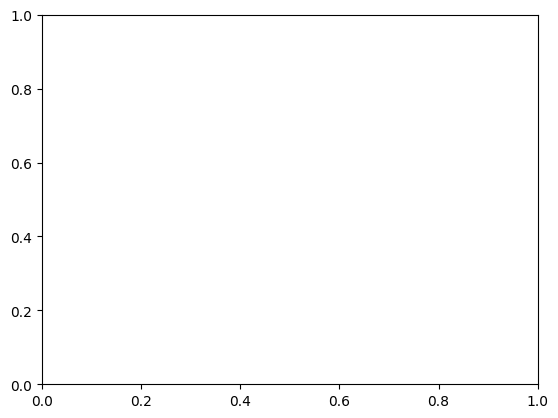

In [97]:
plt.plot(contrib)
plt.xlabel("Block")
plt.ylabel("CLS importance")
plt.show()

In [90]:
heatmap = map_to_image(block_maps[:,:,0], real_image.size)
overlay = overlay_heatmap(real_image, heatmap, alpha=0.5)

plt.imshow(overlay)
plt.axis("off")
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [63]:
# fake_path = "/content/RINE-extended/demo/zzrybysskm.jpg"
# fake_image = Image.open(fake_path).convert("RGB")
# fake_tensor = transforms(fake_image).unsqueeze(0).to(device)
# fake_logit = model(fake_tensor)[0]
# fake_probability = torch.sigmoid(fake_logit)
# print(
#     f"fake image - prob. to be fake: {fake_probability.detach().cpu().numpy()[0][0]*100:1.1f}%"
# )
